In [1]:
import pickle

dictName = f'../../data/T2Dcounts.pkl'
dataMap = None

with open(dictName, 'rb') as f:
    dataMap = pickle.load(f)
    
print(list(dataMap.keys()))
print('Complete')

['T2D', 'NGT', 'T2D_001', 'NGT_003', 'T2D_002', 'NGT_010', 'T2D_006', 'T2D_007', 'NGT_016', 'T2D_009', 'NGT_018', 'T2D_011', 'NGT_020', 'T2D_012', 'NGT_021', 'T2D_017', 'NGT_022', 'T2D_019', 'NGT_023', 'T2D_024', 'NGT_027', 'T2D_026', 'NGT_028', 'T2D_030', 'NGT_033', 'T2D_031', 'NGT_050', 'T2D_035', 'NGT_052', 'T2D_101', 'NGT_123', 'T2D_104', 'NGT_124', 'T2D_107', 'T2D_108', 'NGT_127', 'T2D_109', 'T2D_112', 'NGT_129', 'T2D_119']
Complete


In [2]:
print(dataMap['T2D'])
print(dataMap['NGT'])
print(list(dataMap['T2D_001'].keys()))

{'T2D_011', 'T2D_017', 'T2D_109', 'T2D_002', 'T2D_026', 'T2D_031', 'T2D_009', 'T2D_024', 'T2D_119', 'T2D_012', 'T2D_019', 'T2D_007', 'T2D_108', 'T2D_035', 'T2D_030', 'T2D_001', 'T2D_101', 'T2D_107', 'T2D_104', 'T2D_006', 'T2D_112'}
{'NGT_124', 'NGT_018', 'NGT_003', 'NGT_021', 'NGT_010', 'NGT_020', 'NGT_033', 'NGT_022', 'NGT_123', 'NGT_127', 'NGT_027', 'NGT_052', 'NGT_016', 'NGT_028', 'NGT_050', 'NGT_023', 'NGT_129'}
['basal', 'post', 'rec']


In [3]:
countName = '../../data/GSE202295_gene_counts.txt'

import re
import numpy as np

pat = re.compile('".*" "(.*)" "(.*)" (.*)')

def parseCountsLine(line, pat):
    res = pat.search(line)
    try:
        groups = res.groups()
        counts = [int(c) for c in groups[2].split(' ')]
        return (groups[0], groups[1], counts)
    except Exception as e:
        return None
    
def parseCountsFirstLine(line):
    parts = line.split(' ')
    pat = re.compile('"([^A]+).*"')
    countsMap = {}
    for i in range(2,len(parts)):
        sampleId = pat.search(parts[i]).groups()[0]
        countsMap[sampleId] = i-2
    return countsMap
    
countsAll = []
countNames1 = []
countNames2 = []
countsMap = None

with open(countName, 'r') as f:
    for line in f.readlines():
        res = parseCountsLine(line, pat)
        if res is None:
            countsMap = parseCountsFirstLine(line)
            continue
        n1,n2,counts = res
        countNames1.append(n1)
        countNames2.append(n2)
        countsAll.append(np.array(counts))
        
countsAll = np.stack(countsAll)
print(countsAll.shape)
print(countNames2[0:10])
print('Complete')

(66023, 111)
['RP11-399E6.2', 'AC093151.1', 'FO681542.1', 'RP11-399E6.4', 'DPPA2P2', 'RPS6KA1', 'MIR1976', 'RN7SL679P', 'Y_RNA', 'RNU7-29P']
Complete


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    avg = 0
    for para in range(nPara):
        avg += res[para]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, inp, dp=0.5, edp=0, wInit=1e-4, temp=1):
        super(LatSim, self).__init__()
        self.B = nn.Parameter(wInit*torch.randn(1,inp.shape[-1],1).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.temp = temp
        
    def getEdges(self, X, para):
        e = 1e-10
        z = X[:,para,:]@self.B[para]
        e = e+z@z.T
        return e
    
    def forward(self, x, y, testIdcs=None, temp=None):
        if temp is not None:
            self.temp = temp
        x = self.dp(x)
        res = []
        es = []
        for para in range(1):
            e = self.getEdges(x, para)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = mask(e)
            e = self.edp(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e/self.temp, dim=1)
            res.append(e@y)
            es.append(e)
        return res, es
    
def validate(model, X, y, testIdcs):
    model.eval()
    loss = None
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        r = getAvg(res)
        if y.dim() == 1:
            loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, r

def binLoss(w):
    mag = torch.abs(w)
    maxMag = torch.max(mag, keepdim=True, dim=1).values
    p = mag/maxMag
    return -torch.sum(p*torch.log(p+1e-10))

print('Complete')

Complete


In [23]:
import re

imp = []
with open('../../data/omics-regions/post_100splits_WCountDiff_LatSim_numbers.txt', 'r') as f:
    for line in f.readlines():
        imp.append(int(line)) #[int(num) for num in re.split('\s+', line) if len(num) > 0]
        
imp = np.array(imp)
print(imp)

[24312 24313 30556  8345 62845  3252 16479 56415 59387 13946 62852 31259
 27356 30870 57034  5284 16896 19863 35941 22199]


In [24]:
import sys

sys.path.append('../../src')

from imagenomer import Analysis, JsonData, JsonSubjects, JsonFCMetadata

a,b = np.triu_indices(264,1)
idcs = np.arange(34716)

labels = [f'{a[i]}-{b[i]}' for i in idcs]

print(labels[0:10])
print(labels[-10:])

import numpy as np
import random

def getSamples(dataMap, timep):
    ngt = []
    t2d = []
    for sid in dataMap['NGT']:
        if timep in dataMap[sid]:
            ngt.append(dataMap[sid][timep])
    for sid in dataMap['T2D']:
        if timep in dataMap[sid]:
            t2d.append(dataMap[sid][timep])
    return np.stack(ngt), np.stack(t2d)

mseLoss = nn.MSELoss()
ceLoss = nn.CrossEntropyLoss()

nRuns = 100

tot = []

nEpochs = 1000
pPeriod = 5
thresh = 0.01
binParam = 0
L2 = 0
DP = 0.2
EDP = 0.1
lr = 1e-1
timep = 'post'

model = f'LatentSimilarity EntropyReg={binParam} L2={L2} DP={DP} EDP={EDP} lr={lr}'
desc = f'T2D({timep}) vs NGT({timep}) exercise muscle biopsy genecounts W*Count Diff'
analysis = Analysis(f'{desc}: {model}', 'localhost', 8000)

for run in range(nRuns):
    ngt, t2d = getSamples(dataMap, timep)
    np.random.shuffle(ngt)
    np.random.shuffle(t2d)
    a = int(3*ngt.shape[0]/4)
    b = int(3*t2d.shape[0]/4)
    c = ngt.shape[0]-a
    d = t2d.shape[0]-b
    Xtrain = np.concatenate([ngt[:a], t2d[:b]])
    Xtest = np.concatenate([ngt[a:], t2d[b:]])
    ytrain = np.concatenate([np.zeros(a), np.ones(b)])
    ytest = np.concatenate([np.zeros(c), np.ones(d)])
    
    Xtrain = Xtrain[:,imp]
    Xtest = Xtest[:,imp]
    
#     mu_Xtrain = np.mean(Xtrain, axis=0, keepdims=True)
#     sd_Xtrain = np.std(Xtrain, axis=0, keepdims=True)
    
#     sd_Xtrain[sd_Xtrain == 0] = 1
    
#     Xtrain = (Xtrain-mu_Xtrain)/sd_Xtrain
#     Xtest = (Xtest-mu_Xtrain)/sd_Xtrain
    Xtrain /= np.max(Xtrain, axis=1, keepdims=True)
    Xtest /= np.max(Xtest, axis=1, keepdims=True)
    
    Xtrain_t = torch.from_numpy(Xtrain).unsqueeze(1).float().cuda()
    Xtest_t = torch.from_numpy(Xtest).unsqueeze(1).float().cuda()
    X_t = torch.cat([Xtrain_t, Xtest_t])
    
    ytrain_t = torch.from_numpy(ytrain)
    ytest_t = torch.from_numpy(ytest)
    
    ytrain_t = torch.stack([ytrain_t, 1-ytrain_t], dim=1).float().cuda()
    ytest_t = torch.stack([ytest_t, 1-ytest_t], dim=1).float().cuda()
    
    y_t = torch.cat([ytrain_t, ytest_t])

#     print(Xtrain_t.shape)
#     print(Xtest_t.shape)
#     print(ytrain_t.shape)
#     print(ytest_t.shape)
    
    sim = LatSim(Xtrain_t, dp=DP, edp=EDP, wInit=1e-4)
    optim = torch.optim.Adam(sim.parameters(), lr=lr, weight_decay=L2)
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(Xtrain_t, ytrain_t, temp=1)
        loss = []
        if ytrain_t.dim() > 1:
            loss.append(ceLoss(res[0], ytrain_t))
        else:
            loss.append(mseLoss(res[0], ytrain_t))
        loss.append(binParam*binLoss(sim.B))
        sum(loss).backward()
        optim.step()
#         if epoch % pPeriod == 0 or epoch == nEpochs-1 or all([ls < thresh for ls in loss]):
#             print(f'epoch {epoch} loss={loss}')
            
    ntr = ytrain_t.shape[0]
    ntst = ytest_t.shape[0]
    acc, r = validate(sim, X_t, y_t, np.arange(ntr,ntr+ntst))
    
    print(f'{run}. {acc}')
    
    tot.append(float(acc))
#     break
    
    w = np.sum(np.abs(sim.B[0].detach().cpu().numpy()), axis=1).astype('float64')
    wHC = np.mean(np.expand_dims(w,0)*Xtrain[:25], axis=0)
    wFM = np.mean(np.expand_dims(w,0)*Xtrain[25:], axis=0)
    w = wHC-wFM
    w = np.abs(w)
    w = w/np.max(w)
    
    jsonCompare = desc
    jsonAccuracy = float(acc)
    jsonTrain = [a,b]
    jsonTest = [c,d]
    jsonWeights = w
    jsonLabels = [int(idx) for idx in list(np.arange(Xtrain.shape[1]))] #countNames2

    jsonObj = {
        'Compare': jsonCompare,
        'Model': 'Logistic Regression',
        'Accuracy': jsonAccuracy,
        'Train': jsonTrain,
        'Test': jsonTest,
        'Weights': list(jsonWeights),
        'Labels': jsonLabels
    }
    
    dat = JsonData(analysis)
    dat.dict.update(jsonObj)
    r = dat.post()
    print(r.content)
    
#     print(r[:ntr])
#     print(r[ntr:])
    
tot = np.array(tot)
print(np.mean(tot))
print(np.std(tot))

['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10']
['259-260', '259-261', '259-262', '259-263', '260-261', '260-262', '260-263', '261-262', '261-263', '262-263']
0. 0.7777777910232544
b'Success'
1. 0.6666666865348816
b'Success'
2. 0.6666666865348816
b'Success'
3. 0.7777777910232544
b'Success'
4. 0.7777777910232544
b'Success'
5. 0.7777777910232544
b'Success'
6. 0.8888888955116272
b'Success'
7. 0.8888888955116272
b'Success'
8. 0.6666666865348816
b'Success'
9. 0.8888888955116272
b'Success'
10. 0.6666666865348816
b'Success'
11. 0.6666666865348816
b'Success'
12. 0.7777777910232544
b'Success'
13. 0.6666666865348816
b'Success'
14. 0.6666666865348816
b'Success'
15. 0.7777777910232544
b'Success'
16. 0.8888888955116272
b'Success'
17. 0.8888888955116272
b'Success'
18. 0.7777777910232544
b'Success'
19. 0.5555555820465088
b'Success'
20. 0.5555555820465088
b'Success'
21. 0.7777777910232544
b'Success'
22. 0.5555555820465088
b'Success'
23. 0.7777777910232544
b'Success'
24. 0.88888

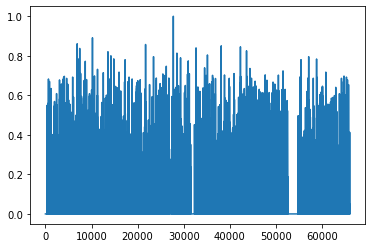

In [40]:
import matplotlib.pyplot as plt

wnp = sim.B[0,:,0].detach().cpu().numpy()
idcs = np.argsort(wnp)

plt.plot(w)
plt.show()

In [13]:
ngt, t2d = getSamples(dataMap, timep)
ngt = np.stack(ngt)
t2d = np.stack(t2d)

X = np.concatenate([ngt, t2d])
X = X.T

y = np.concatenate([np.ones((1,len(ngt))), -np.ones((1,len(t2d)))], axis=1)
y = np.repeat(y, 66023, axis=0)

print(y.shape)
print(X.shape)

sxy = np.einsum('ab,ab->a',X,y)
sxx = np.einsum('ab,ab->a',X,X)
syy = np.einsum('ab,ab->a',y,y)

rho = sxy/np.sqrt(sxx*syy)

print(rho.shape)
print(np.sum(np.isnan(rho)))

rho[np.isnan(rho)] = 0

idcs = np.argsort(np.abs(rho))

print(rho[idcs[-1:-21:-1]])
print(idcs[-1:-21:-1])

(66023, 36)
(66023, 36)
(66023,)
28437
[-0.49746834 -0.48291214 -0.46423835 -0.46423835 -0.46342756 -0.46225016
 -0.4614791  -0.45226702  0.45226702 -0.45139689 -0.4454354  -0.44339818
 -0.44307094 -0.4330127  -0.43212081 -0.43207928 -0.42699864 -0.42640143
 -0.42600643 -0.42326983]
[43567 26941 52161 59236 23705  3014 12102  8093 33518 18699 60217 29246
 26520 11845 47688  8623 35479 25801  2369 18803]


/tmp/ipykernel_2645986/2638014510.py:18: RuntimeWarning: invalid value encountered in divide
  rho = sxy/np.sqrt(sxx*syy)
